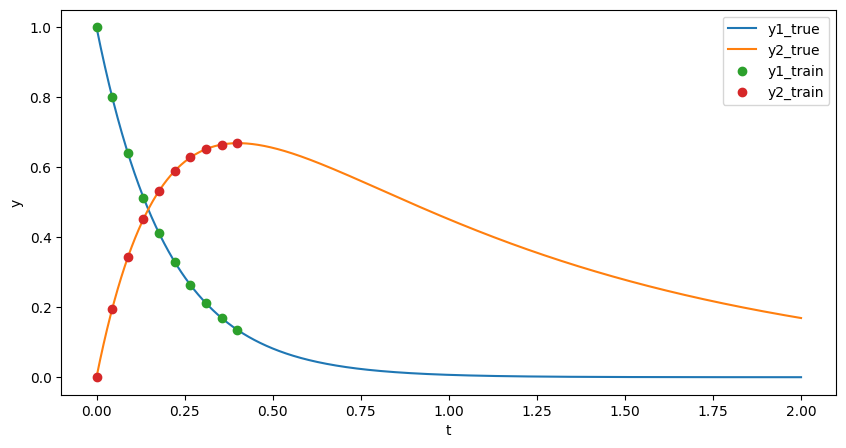

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint

class Data:
    def __init__(self):
        self.k1 = 5
        self.k2 = 1
        self.y1_0 = 1
        self.y2_0 = 0
        
        self.times = np.linspace(0, 2, 1000)    
        
    def analytical_solution(self, t):
        y1_true = np.exp(-self.k1 * t)
        y2_true = 5/4 * np.exp(-5 * t) * (-1 + np.exp(4 * t))
        return y1_true, y2_true
    
    def ode_func(self, t, y):
        dy1_dt = -self.k1 * y[0]
        dy2_dt = self.k1 * y[0] - self.k2 * y[1]
        return [dy1_dt, dy2_dt]
    
    def solve_ode(self, t_eval):
        return solve_ivp(self.ode_func, [0, 2], [self.y1_0, self.y2_0], t_eval=t_eval)

    def train_data(self):
        t_train = np.linspace(0, .4, 10)
        sol = self.solve_ode(t_train)
        y_train_1 = sol.y[0]
        y_train_2 = sol.y[1]
        return t_train, y_train_1, y_train_2
    
data = Data()
t_true = np.linspace(0, 2, 1000)
# y1_true, y2_true = data.analytical_solution(t_true)
solution = data.solve_ode(t_true)
y1_true = solution.y[0]
y2_true = solution.y[1]
t_train, y_train_1, y_train_2 = data.train_data()
y_train = np.column_stack((y_train_1, y_train_2))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t_true, y1_true, label='y1_true')
plt.plot(t_true, y2_true, label='y2_true')
plt.plot(t_train, y_train[:,0], 'o', label='y1_train')
plt.plot(t_train, y_train[:,1], 'o', label='y2_train')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim

t_train_ts = torch.tensor(t_train, dtype=torch.float32).reshape(-1, 1)
y_train_ts = torch.tensor(y_train, dtype=torch.float32).view(-1,y_train.shape[1])

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc  = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc(x))
        x = self.fc2(x)
        return x

In [62]:
physics = True

def physics_loss(model: nn.Module):
    t = np.linspace(0, 2, 250)
    t_ts = torch.tensor(t, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y_pred_ts = model(t_ts)
    y_pred_1_ts = y_pred_ts[:, 0]
    y_pred_2_ts = y_pred_ts[:, 1]
    
    dy_pred_1_ts_dt = torch.autograd.grad(y_pred_1_ts, t_ts, torch.ones_like(y_pred_1_ts), create_graph=True)[0]
    dy_pred_2_ts_dt = torch.autograd.grad(y_pred_2_ts, t_ts, torch.ones_like(y_pred_2_ts), create_graph=True)[0]
    
    error_1 = dy_pred_1_ts_dt + 5 * y_pred_1_ts
    error_2 = dy_pred_2_ts_dt - 5 * y_pred_1_ts + y_pred_2_ts
    
    return torch.mean(error_1)**2 + torch.mean(error_2)**2

In [81]:
model = NN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

model.train()
for epoch in range(5000):
    optimizer.zero_grad()
    y_pred = model(t_train_ts)
    
    loss = criterion(y_pred, y_train_ts)
    
    if physics:
        loss_ode = physics_loss(model)
        
        loss_ic = y_pred[0] - torch.tensor([data.y1_0, data.y2_0])
        loss_ic = torch.mean(loss_ic**2)        
        
        loss += loss_ode + loss_ic

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

Epoch 0, Loss 0.9702150821685791
Epoch 1000, Loss 0.0009328898740932345
Epoch 2000, Loss 4.9504735216032714e-05
Epoch 3000, Loss 3.276109782746062e-05
Epoch 4000, Loss 2.3554164727102034e-05


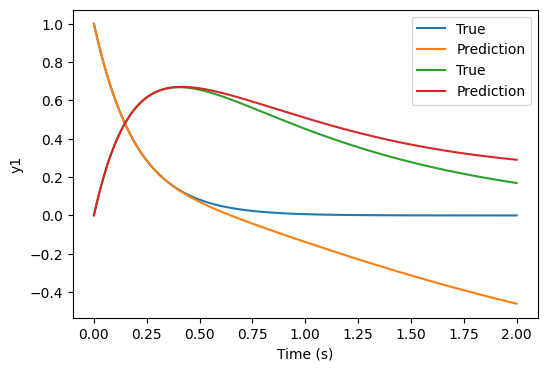

In [80]:
def evaluation(model: nn.Module):
    model.eval()
    t_test = np.linspace(0, 2, 1000)
    solution = data.solve_ode(t_test)
    y_test_1 = solution.y[0]
    y_test_2 = solution.y[1]
    t_test_ts = torch.tensor(t_test, dtype=torch.float32).reshape(-1, 1)
    y_pred_ts = model(t_test_ts)
    y_pred = y_pred_ts.detach().numpy()
    
    plt.figure(figsize=(6,4))
    plt.plot(t_test, y_test_1, label='True')
    plt.plot(t_test, y_pred[:,0], label='Prediction')
    plt.plot(t_test, y_test_2, label='True')
    plt.plot(t_test, y_pred[:,1], label='Prediction')
    plt.ylabel('y1')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.show()
    
evaluation(model)
    